In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sc.constants as cs
from sc import payoff as po
from yq.scripts import simulation as yqsm

print(pd.__version__)

2.1.2


In [2]:
paths_arr = yqsm.read_sim_data('gbm', '20231110_222722_149946', pd.Timestamp('2023-08-09'), pd.Timestamp('2023-08-10'))
#print(paths_arr[1][0])

Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Total sims/length of sim_data_df for 2023-08-09 00:00:00: 3
Total sims/length of sim_data_df for 2023-08-10 00:00:00: 3
Total days is: 2



In [3]:
#prep for single price path

df_sim = paths_arr[1][0]
df_sim = df_sim.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
print(df_sim)

               LONN.SE     SIKA.SE
Date                              
2023-08-11  473.661553  265.686885
2023-08-14  469.086618  262.894438
2023-08-15  473.539181  258.579333
2023-08-16  475.471892  262.922544
2023-08-17  474.120026  263.971279
...                ...         ...
2024-07-24  568.073957  357.164751
2024-07-25  563.140520  361.756420
2024-07-26  563.944847  359.278574
2024-07-29  547.420888  360.864363
2024-07-30  548.441721  361.281909

[243 rows x 2 columns]


In [6]:
po.pricing_single(df_sim)
po.payouts(df_sim, False)

,Payout
Date,
2023-11-06,20.0
2024-02-05,20.0
2024-05-06,20.0
2024-05-06,1000.0


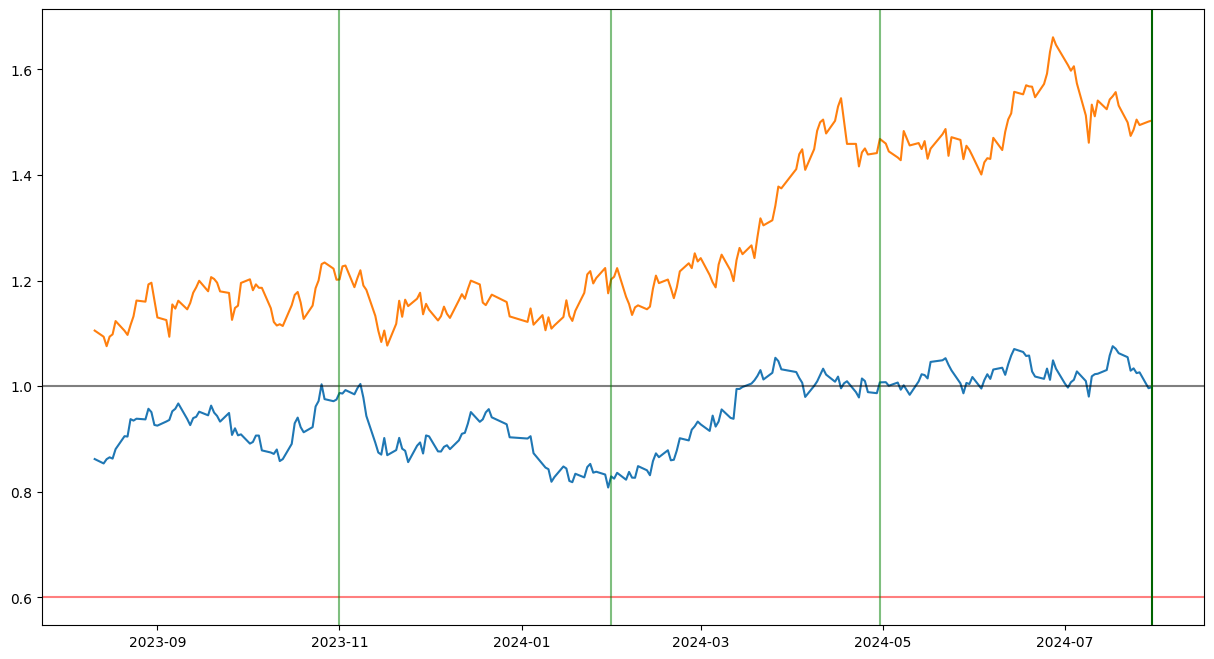

In [5]:
df_plot = df_sim.copy(deep = True)
for asset in cs.ASSET_NAMES:
    df_plot[asset] = df_plot[asset] / cs.INITIAL_LEVELS[asset]
plt.figure(figsize = (15, 8))
plt.plot(df_plot)
plt.axhline(y=1, c = "black", alpha = 0.5)
plt.axhline(y = 0.6, c = "red", alpha = 0.5)
plt.axvline(x = cs.FINAL_FIXING_DATE, c = "darkgreen")
for date in cs.EARLY_REDEMPTION_OBSERVATION_DATES:
    plt.axvline(x = date, c = "green", alpha = 0.5)

In [7]:
#multi path testing
df_sim_array = paths_arr[1]
for i in range(len(df_sim_array)):
    df_sim_array[i] = df_sim_array[i].rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
po.pricing_multiple(df_sim_array)

            Payout
Date              
2023-11-06    20.0
2024-02-05    20.0
2024-05-06    20.0
2024-05-06  1000.0
[1060.0]
            Payout
Date              
2023-11-06    20.0
2024-02-05    20.0
2024-05-06    20.0
2024-05-06  1000.0
[1060.0, 1060.0]
            Payout
Date              
2023-11-06    20.0
2024-02-05    20.0
2024-05-06    20.0
2024-05-06  1000.0
[1060.0, 1060.0, 1060.0]


[1060.0, 1060.0, 1060.0]